In [69]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')

In [70]:
y = df['SalePrice']
df = df.drop('SalePrice', axis=1)


In [71]:
all_columns = df.columns
category_columns = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1','Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                    'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
                    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
linear_columns = [col for col in all_columns if col not in category_columns]

План наш таков:
1) Смотрим и избавляемся от пропущенных значений
2) One hot'им или mean hot'им категориальные фичи
3) Проверяем вещественные фичи на линейную зависимость, избавляемся от мультиколлинеарности
4) Строим таблицу корреляций

In [72]:
hard_na_cols = df.columns[df.isna().sum() > len(df) / 10]
soft_na_cols = [col for col in df.columns[df.isna().any()] if col not in hard_na_cols]
hard_na_cols, soft_na_cols

hard_na_category = [c for c in hard_na_cols if c in category_columns]
hard_na_linear = [c for c in hard_na_cols if c in linear_columns]

soft_na_category = [c for c in soft_na_cols if c in category_columns]
soft_na_linear = [c for c in soft_na_cols if c in linear_columns]

hard_na_category, hard_na_linear, soft_na_category, soft_na_linear

(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'],
 ['LotFrontage'],
 ['BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 ['MasVnrArea', 'GarageYrBlt'])

Alley - для NA нет доступа к аллее
Можно разбить на бинарный "есть ли доступ к аллее" и для тех, у которых есть, создать бинарник для типа доступа

LotFrontage - для NA Нет информации
Можно заполнить информацию по средним, наверное

MasVnrType - для NA нет каменной кладки
Тоже самое, что и с Alley

FireplaceQu - для NA нет Fireplace
Mean hotим это, а то создадим 7 новых фич

PoolQC - для НА нет бассеина
Mean hotiм это 

Fence - Для NA нет fence
Mean hotим это, а то создадим 5 новых фич

MiscFeature - для NA нет "прочих фич"

BsmtQual - высота подвала, для НА нет подвала, mean hot

BsmtCond - качество подвала, для НА нет подвала, mean hot

BsmtExposure - для НА нет подвала, mean hot

BsmtFinType1 - mean hot
BsmtFinType2 - mean hot

Electrical - Для НА нет данных, хз чо придумать. 

'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond' - гаражные колонки, для NA нет гаража
  
  GarageYrBlt - вычесть 1899, а для НА сделать 0

In [73]:
mean_ec = ['LotConfig', 'LandSlope', 'Neighborhood', 'RoofStyle', 'RoofMatl','BsmtFinType1','BsmtFinType2','Functional', 'MiscFeature','SaleType','BldgType']
ordinal_ec = ['Street', 'LotShape', 'LandContour', 'Utilities', 'Condition1', 'Condition2', 'HouseStyle', 'Exterior1st', 'Exterior2nd',
              'ExterQual', 'ExterCond','Foundation','BsmtQual', 'BsmtCond','BsmtExposure','HeatingQC','KitchenQual',
              'FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond','PoolQC','Fence','SaleCondition','Alley']
one_ec = ['MSZoning','MasVnrType','Heating','CentralAir','Electrical','PavedDrive']

In [74]:
df[category_columns] = df[category_columns].fillna('NaN')
df_test[category_columns] = df_test[category_columns].fillna('NaN')

In [75]:
from sklearn.preprocessing import OrdinalEncoder

coder = OrdinalEncoder()
df[ordinal_ec] = coder.fit_transform(df[ordinal_ec])
df_test[ordinal_ec] = coder.fit_transform(df_test[ordinal_ec])

In [76]:
df = pd.get_dummies(df, columns = one_ec, drop_first=True)
df_test = pd.get_dummies(df_test, columns = one_ec, drop_first=True)

In [77]:
for col in mean_ec:
    mean_encoding = df.join(y).groupby(col)['SalePrice'].mean().to_dict()
    df[col] = df[col].map(mean_encoding)
    #df_test[col].fillna(df_test[col].mean(), inplace=True)



In [78]:
df_test[mean_ec] = coder.fit_transform(df_test[mean_ec])

In [79]:
df = df.astype(np.float64)
df_test = df_test.astype(np.float64)

In [80]:
df.isna().sum()
print(df_test.isna().sum().sum())
df_test.isna().sum()

330


MSSubClass            0
LotFrontage         227
LotArea               0
Street                0
Alley                 0
                   ... 
Electrical_FuseF      0
Electrical_FuseP      0
Electrical_SBrkr      0
PavedDrive_P          0
PavedDrive_Y          0
Length: 90, dtype: int64

In [82]:
lin_na_cols = df.columns[df.isna().any()].tolist()

for col in lin_na_cols:
    a = df[col].isna().sum()
    print(a / df.shape[0], col)

lin_na_cols = df_test.columns[df_test.isna().any()].tolist()
print()
for col in lin_na_cols:
    a = df_test[col].isna().sum()
    print(a / df_test.shape[0], col)

0.1773972602739726 LotFrontage
0.005479452054794521 MasVnrArea
0.05547945205479452 GarageYrBlt

0.15558601782042494 LotFrontage
0.01028101439342015 MasVnrArea
0.0006854009595613434 BsmtFinSF1
0.0006854009595613434 BsmtFinSF2
0.0006854009595613434 BsmtUnfSF
0.0006854009595613434 TotalBsmtSF
0.0013708019191226869 BsmtFullBath
0.0013708019191226869 BsmtHalfBath
0.053461274845784786 GarageYrBlt
0.0006854009595613434 GarageCars
0.0006854009595613434 GarageArea


In [83]:
try: df.drop('LotFrontage', axis = 1, inplace=True); linear_columns.pop(linear_columns.index('LotFrontage'))
except : print('Уже выбросили1')
try: df.drop('LotFrontage', axis = 1, inplace=True); linear_columns.pop(linear_columns.index('LotFrontage'))
except : print('Уже выбросили1')
try: df.drop('GarageYrBlt', axis = 1, inplace=True);linear_columns.pop(linear_columns.index('GarageYrBlt'))
except : print('Уже выбросили2')
try: df_test.drop('LotFrontage', axis = 1, inplace=True); linear_columns.pop(linear_columns.index('LotFrontage'))
except : print('Уже выбросили1')
try: df_test.drop('LotFrontage', axis = 1, inplace=True); linear_columns.pop(linear_columns.index('LotFrontage'))
except : print('Уже выбросили1')
try: df_test.drop('GarageYrBlt', axis = 1, inplace=True);linear_columns.pop(linear_columns.index('GarageYrBlt'))
except : print('Уже выбросили2')

Уже выбросили1
Уже выбросили1
Уже выбросили1
Уже выбросили2


In [100]:
lin_na_cols = df.columns[df.isna().any()].tolist()
for col in lin_na_cols:
    a = df[col].isna().sum()
    print(a / df.shape[0], col)
print('--' * 17)
lin_na_cols_test = df_test.columns[df_test.isna().any()].tolist()
for col in lin_na_cols_test:
    a = df_test[col].isna().sum()
    print(a / df_test.shape[0], col)
    

----------------------------------


In [92]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())

In [99]:
for i in lin_na_cols_test:
    df_test[i] = df_test[i].fillna(df_test[i].mean())

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

model = LinearRegression()
model.fit(df, y)
preds = model.predict(df)

print('rmse:',mse(preds, y) ** 0.5)

rmse: 28302.189193947874


In [102]:
y.mean()

180921.19589041095

In [103]:
len(linear_columns)

34

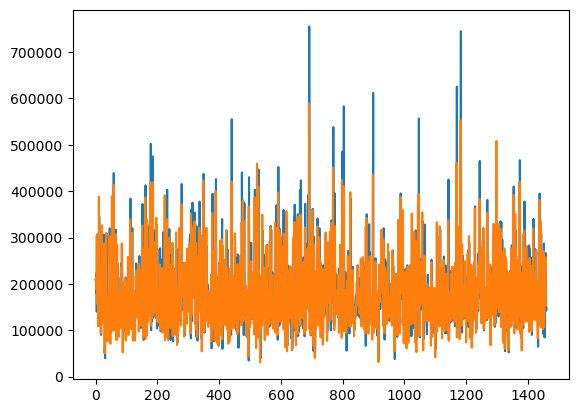

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.plot(y)
plt.plot(preds)

<Figure size 640x480 with 0 Axes>

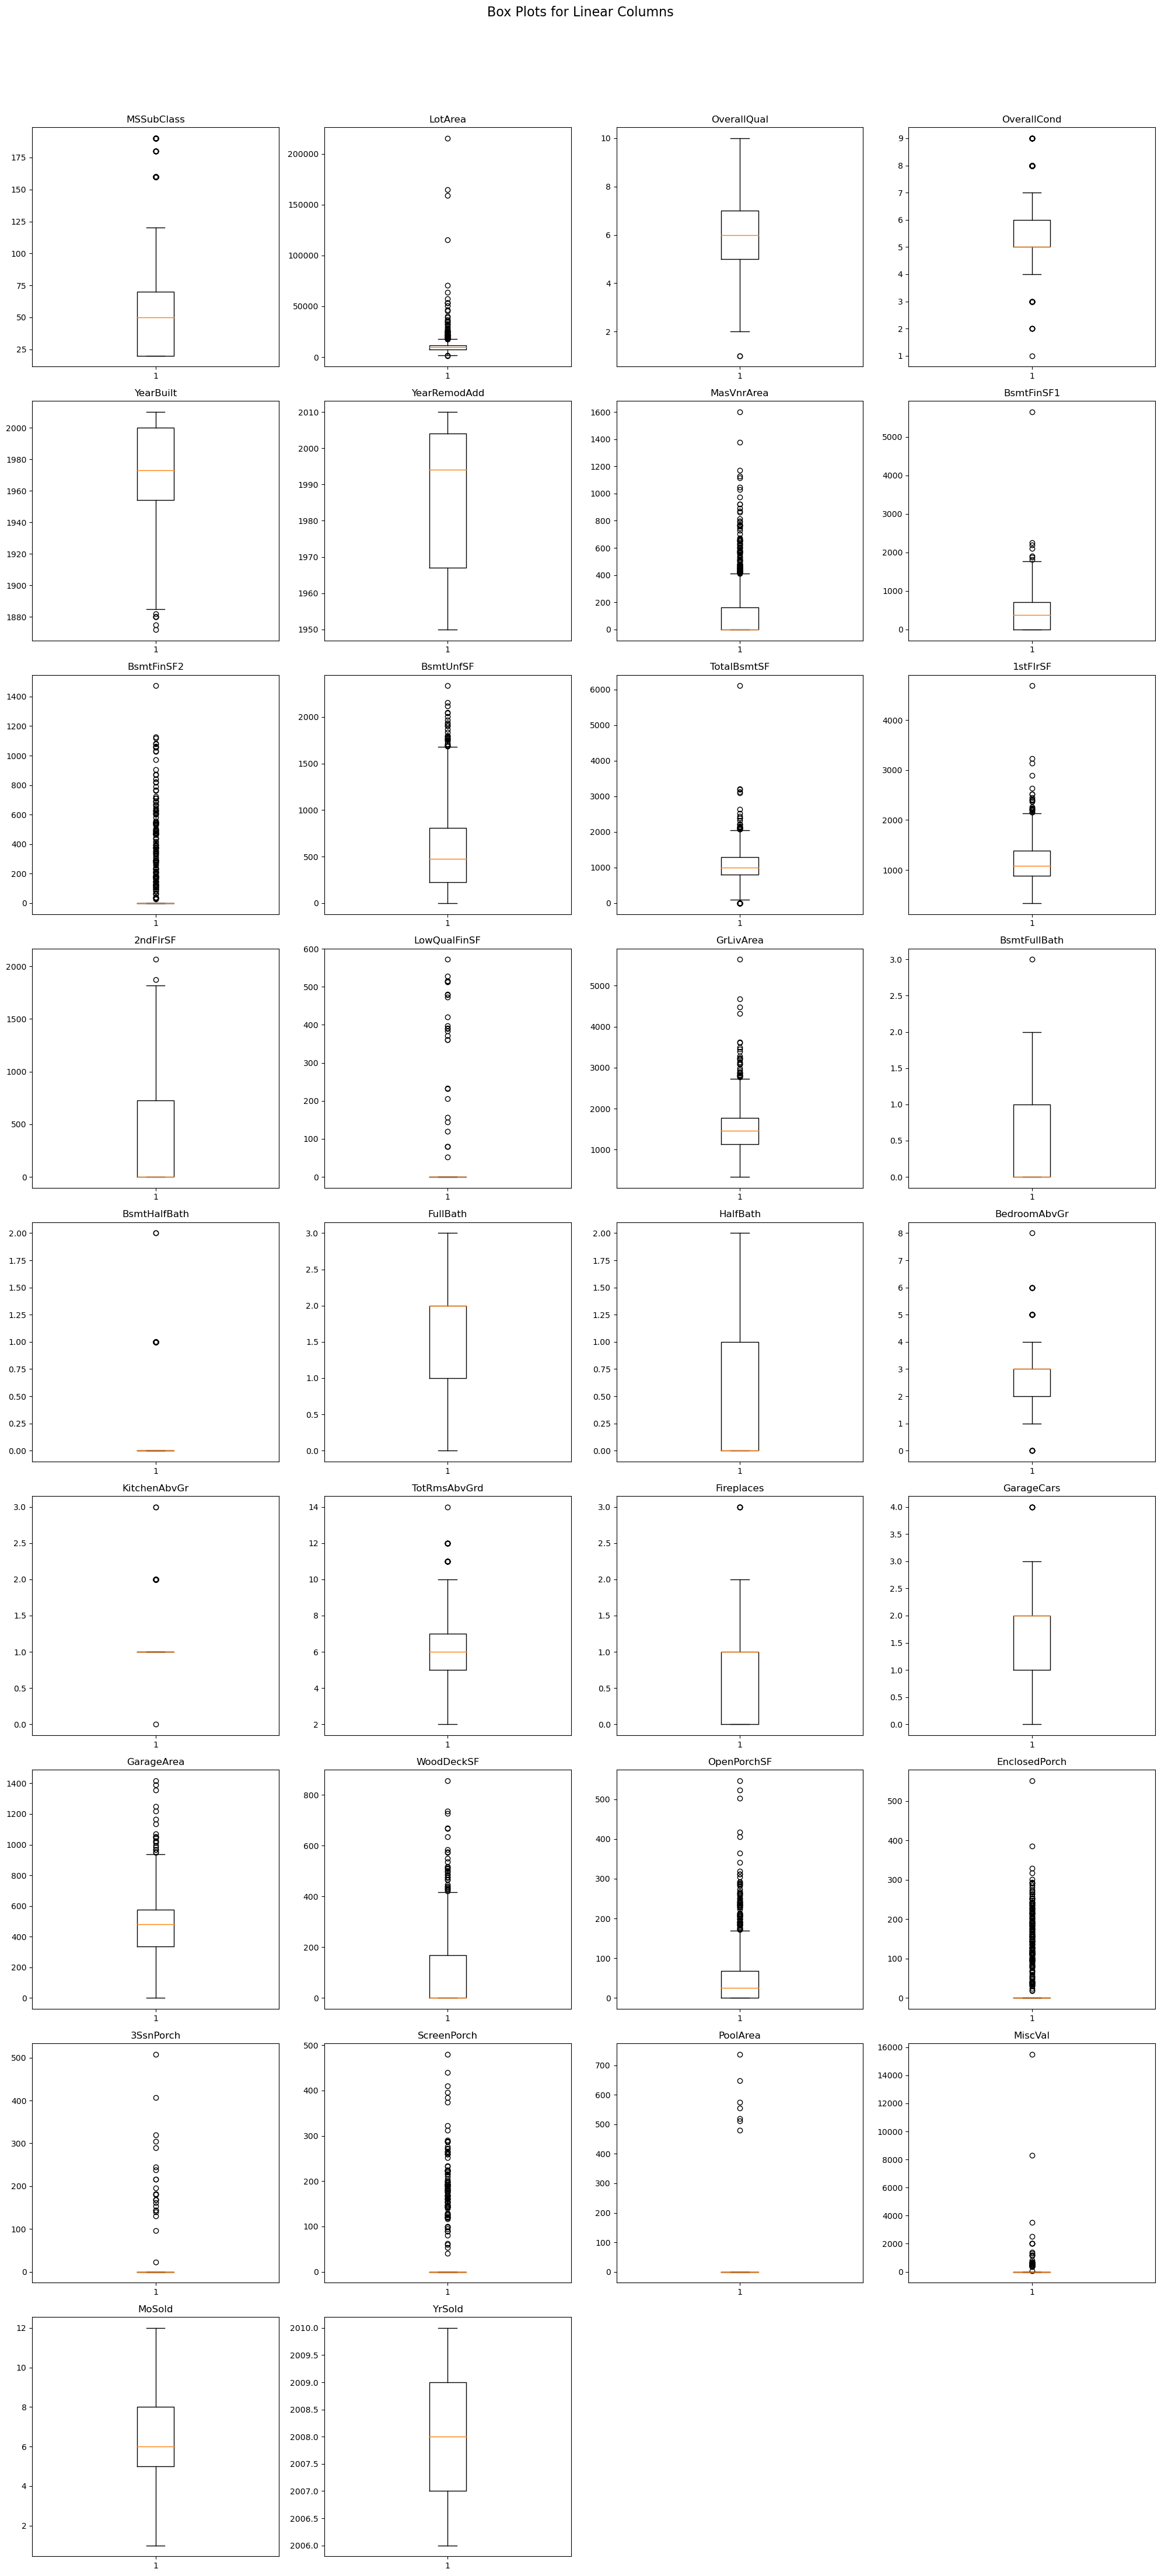

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()

# до анализа выбросов 
columns_per_row = 4
num_columns = len(linear_columns)
num_rows = (num_columns + columns_per_row - 1) // columns_per_row

# Создание фигуры и сетки подграфиков
fig, axs = plt.subplots(num_rows, columns_per_row, figsize=(20, 5 * num_rows))

# Цикл для построения графиков
for i, col in enumerate(linear_columns):
    row = i // columns_per_row
    col_idx = i % columns_per_row
    
    # Построение боксплота в соответствующей ячейке
    if num_rows == 1:
        axs[col_idx].boxplot(df[col])
        axs[col_idx].set_title(col)
    else:
        axs[row, col_idx].boxplot(df[col])
        axs[row, col_idx].set_title(col)

# Удаление пустых подграфиков, если есть
for j in range(i + 1, num_rows * columns_per_row):
    row = j // columns_per_row
    col_idx = j % columns_per_row
    fig.delaxes(axs[row, col_idx])

# Добавление общего заголовка для всей фигуры
fig.suptitle('Box Plots for Linear Columns', fontsize=16)

# Подстройка расположения элементов для предотвращения наложения
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Отображение графиков
plt.show()

In [104]:
for col in linear_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтрация данных для удаления выбросов
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in linear_columns:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтрация данных для удаления выбросов
    df_test = df_test[(df_test[col] >= lower_bound) & (df_test[col] <= upper_bound)]


In [105]:
df.shape, df_test.shape

((578, 91), (548, 88))

In [106]:
y = y[y.index.isin(df.index)]

In [107]:
removed_indices = df.index.difference(y.index)
# Удаление элементов из серии y по индексам
y_cleaned = y.drop(removed_indices)

In [108]:
y.shape

(578,)

In [109]:
new_model = LinearRegression()

new_model.fit(df, y)
new_preds = new_model.predict(df)
rmse = mse(new_preds, y) ** 0.5
print('rmse:', rmse)

rmse: 16807.341359643553


In [27]:
y.mean()

181439.76297577855

In [30]:
from sklearn.metrics import mean_squared_log_error as msle 

rmsle = msle(y, new_preds) ** 0.5 
print(rmsle)

0.09998657348184219


In [110]:
y_test = new_model.predict(df_test)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- MSZoning_NaN
Feature names seen at fit time, yet now missing:
- Electrical_Mix
- Electrical_NaN
- Heating_GasA
- Heating_OthW
